In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


In [2]:
from PIL import Image

In [3]:
img_path = '/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg'


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, img_folder_path, transform=None):
        self.img_folder_path = img_folder_path
        self.transform = transform
        self.img_paths = [os.path.join(img_folder_path, fname) for fname in os.listdir(img_folder_path) if fname.endswith('.jpg')]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img

# Exemple d'utilisation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

img_folder_path = img_path # Change ici le chemin vers ton dossier d'images
dataset = CustomImageDataset(img_folder_path, transform=transform)


In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])
dataset = datasets.ImageFolder(root=img_path, transform=transform)

In [8]:

class UnlabeledDataset(Dataset):
    def __init__(self, labeled_dataset):
        self.labeled_dataset = labeled_dataset

    def __len__(self):
        return len(self.labeled_dataset)

    def __getitem__(self, idx):
        # Return only the image, ignore the label
        image, _ = self.labeled_dataset[idx]
        return image

# Apply it to your existing ImageFolder dataset
unlabeled_dataset = UnlabeledDataset(dataset)

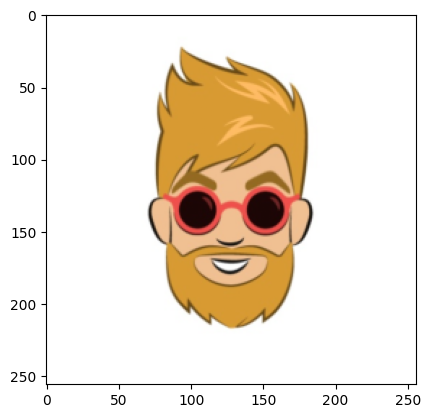

In [9]:
plt.imshow(((unlabeled_dataset[0]+1)/2).permute(1, 2, 0))

In [10]:
dataset = unlabeled_dataset

In [11]:
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [12]:
device = torch.device("cuda"if torch.cuda.is_available() else "cpu")

In [13]:
latent_dim = 100  # Dimension du vecteur latent
img_size = 256 # Taille de l'image d'entrée
channels = 3  # Nombre de canaux (images RGB)

In [14]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_size, channels):
        super(Generator, self).__init__()

        self.init_size = img_size // 8  # On part d'une taille plus petite (256 // 8 = 32)
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 512 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),  # 32 -> 64
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),  # 64 -> 128
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),  # 128 -> 256
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise):
        out = self.l1(noise)
        out = out.view(out.size(0), 512, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

                                                

# Modèle du discriminateur
class Discriminator(nn.Module):
    def __init__(self, img_size, channels):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 3, stride=2, padding=1),  # 256 -> 128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 128 -> 64
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # 64 -> 32
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),  # 32 -> 16
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 3, stride=2, padding=1),  # 16 -> 8
            nn.BatchNorm2d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(1024 * (img_size // 32) * (img_size // 32), 1),  # 1024 * 8 * 8 (pour 256x256)
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity


# Initialiser le générateur et le discriminateur
generator = Generator(latent_dim,  img_size, channels).to(device)
discriminator = Discriminator(img_size, channels).to(device)

# Optimiseurs
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Fonction de perte
adversarial_loss = nn.BCELoss()

# Fonction d'entraînement
def train(epoch, num_epochs=100):
    for i, (imgs) in enumerate(train_loader):
        batch_size = imgs.size(0)

        # Labels réels et faux
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Envoi des images et des labels sur le GPU
        imgs = imgs.to(device)
        

        # Entraîner le générateur
        optimizer_G.zero_grad()

        noise = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(noise)
        
        g_loss = adversarial_loss(discriminator(gen_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Entraîner le discriminateur
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(imgs), real_labels)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake_labels)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Afficher les résultats toutes les 100 itérations
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(train_loader)}] "
                  f"Loss D: {d_loss.item()}, loss G: {g_loss.item()}")


# Démarrer l'entraînement


In [22]:
num_epochs = 2
for epoch in range(num_epochs):
    train(epoch, num_epochs)

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 183.12 MiB is free. Process 3178 has 15.71 GiB memory in use. Of the allocated memory 14.00 GiB is allocated by PyTorch, and 1.40 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [20]:
generator = Generator(latent_dim,  img_size, channels).to(device)
generator.load_state_dict(torch.load("/kaggle/input/generator_anime/pytorch/default/1/generator.pth"))

<ipython-input-20-81cdbc230662>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/kaggle/input/generator_anime/pytorch/default/1/genera

<All keys matched successfully>

In [29]:
num_epochs = 5
for epoch in range(num_epochs):
    train(epoch, num_epochs)

Epoch [0/5] Batch [0/625] Loss D: 1.98817542695906e-05, loss G: 12.22831916809082
Epoch [0/5] Batch [100/625] Loss D: 1.2744374544126913e-05, loss G: 14.070869445800781
Epoch [0/5] Batch [200/625] Loss D: 1.7594471501070075e-05, loss G: 14.880409240722656
Epoch [0/5] Batch [300/625] Loss D: 1.1303933206363581e-05, loss G: 15.197629928588867
Epoch [0/5] Batch [400/625] Loss D: 2.1572044715867378e-05, loss G: 15.246332168579102
Epoch [0/5] Batch [500/625] Loss D: 1.2239774150657468e-05, loss G: 13.634721755981445
Epoch [0/5] Batch [600/625] Loss D: 2.0993113139411435e-05, loss G: 15.606282234191895
Epoch [1/5] Batch [0/625] Loss D: 2.1630277842632495e-05, loss G: 14.811016082763672
Epoch [1/5] Batch [100/625] Loss D: 2.1560848836088553e-05, loss G: 16.834789276123047
Epoch [1/5] Batch [200/625] Loss D: 9.225575922755525e-06, loss G: 14.695931434631348
Epoch [1/5] Batch [300/625] Loss D: 6.424695129680913e-06, loss G: 15.35828971862793
Epoch [1/5] Batch [400/625] Loss D: 2.303999053765437

In [20]:
batch_size = 49 # Nombre d'images à générer
latent_dim = 100  # Dim de ton espace latent
z = torch.randn(batch_size, latent_dim).to(device)
generated_images = generator(z)

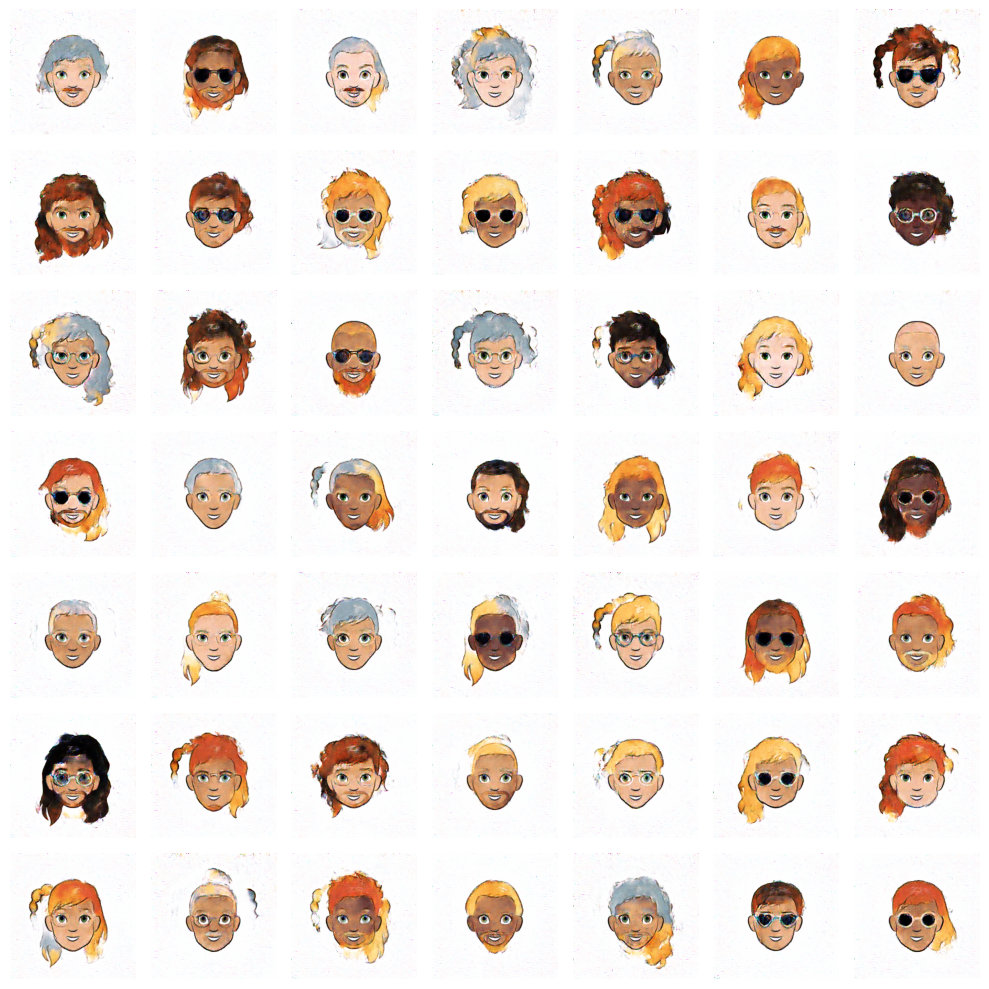

In [21]:
generated_images = (generated_images + 1) / 2  # Si tes valeurs sont dans [-1, 1]
generated_images = generated_images.clamp(0, 1)  # Clamp pour éviter les dépassements

fig, axes = plt.subplots(7, 7, figsize=(10, 10))

for i in range(batch_size):
    ax = axes[i // 7, i % 7]  # Calcul de la position (7x7 pour batch_size=49)
    ax.axis('off')
    ax.imshow(generated_images[i].permute(1, 2, 0).cpu().detach().numpy())

plt.tight_layout()
plt.show()

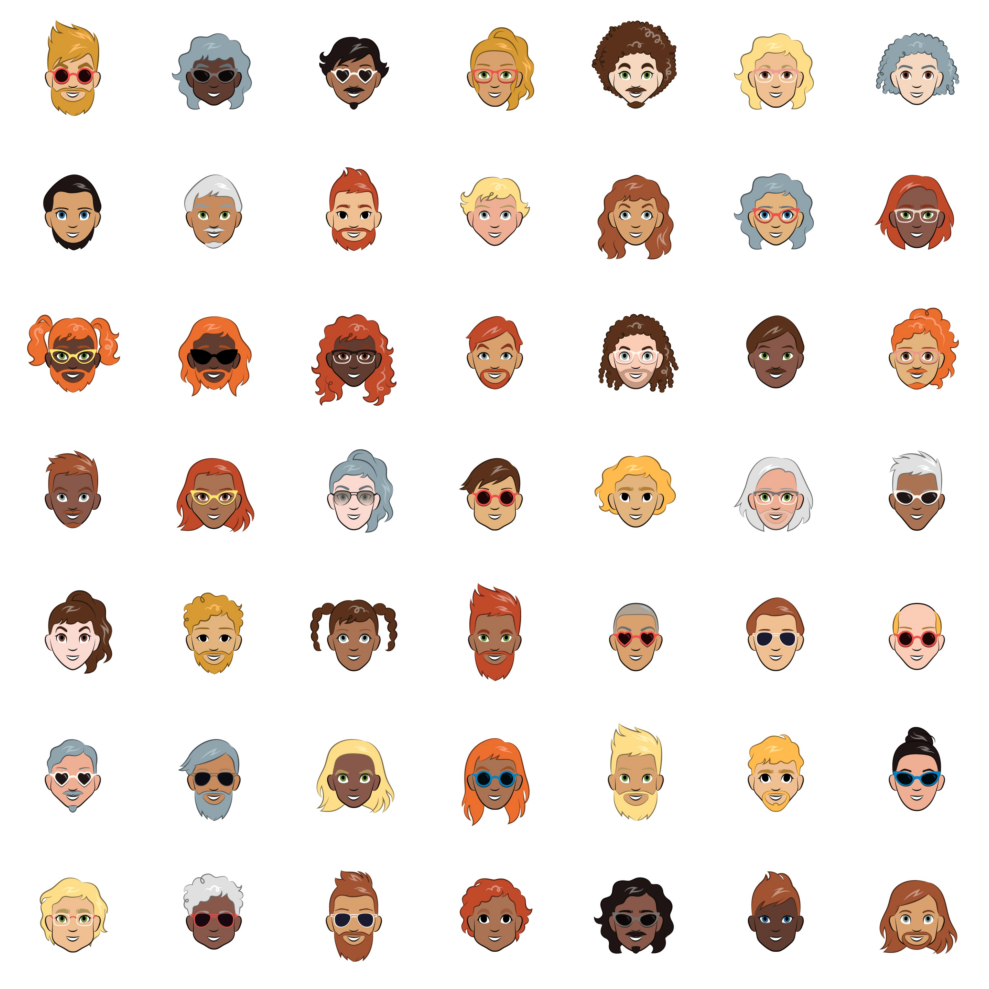

In [23]:
data = [(dataset[i]+1)/2 for i in range(0,49)]
fig, axes = plt.subplots(7, 7, figsize=(10, 10))


for i in range(len(data)):
    ax = axes[i // 7, i % 7]  # Calcul de la position (7x7 pour batch_size=49)
    ax.axis('off')
    ax.imshow(data[i].permute(1, 2, 0).cpu().detach().numpy())

plt.tight_layout()
plt.show()